<a href="https://colab.research.google.com/github/AdityaPathak09/AdityaPathak09/blob/main/CollegePlantIPModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.4'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 75 kB 501 kB/s 
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [ ]:
# verify TensorFlow version
tf.config.list_physical_devices('GPU')

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.9.2
Eager mode:  True
Hub version:  0.4.0
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_file = '/content/drive/MyDrive/docs/Dataset_CollegePhotos'

In [ ]:
data_dir = os.path.join(dir_file, 'Test')
train_dir = os.path.join(dir_file, 'Train')
validation_dir = os.path.join(dir_file, 'Val')

In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/drive/MyDrive/docs/Dataset_CollegePhotos/Train : 345files
total images for validation : /content/drive/MyDrive/docs/Dataset_CollegePhotos/Val : 303files


In [ ]:
import json

with open('/content/drive/MyDrive/docs/categories (1).json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['diseased plant', 'fresh plant']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 2


In [ ]:
module_selection = ("inception_v3", 768, 1024 , 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixelsx, pixelsy, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixelsx, pixelsy)
# IMAGE_SIZE = (1280, 1024)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (768, 1024) and output dimension 2048


In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 303 images belonging to 2 classes.
Found 345 images belonging to 2 classes.


In [ ]:
tf.compat.v1.disable_eager_execution()
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(),
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
# model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 22,852,898
Trainable params: 1,050,114
Non-trainable params: 21,802,784
_____________

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
EPOCHS=30 #@param {type:"integer"}


history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

<ipython-input-20-6bca7a435471>:4: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 31.3000 - loss: 1.4323 - accuracy: 0.5335 

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


10/10 [==============================] - 548s 54s/step - batch: 4.5000 - size: 31.3000 - loss: 1.4323 - accuracy: 0.5335 - val_loss: 1.0994 - val_accuracy: 0.4722
Epoch 2/30
10/10 [==============================] - 162s 18s/step - batch: 4.5000 - size: 31.3000 - loss: 0.9232 - accuracy: 0.5847 - val_loss: 0.9146 - val_accuracy: 0.4722
Epoch 3/30
10/10 [==============================] - 159s 18s/step - batch: 4.5000 - size: 31.3000 - loss: 0.7637 - accuracy: 0.7859 - val_loss: 0.8502 - val_accuracy: 0.4826
Epoch 4/30
10/10 [==============================] - 155s 17s/step - batch: 4.5000 - size: 31.3000 - loss: 0.6907 - accuracy: 0.8882 - val_loss: 0.7301 - val_accuracy: 0.7812
Epoch 5/30
10/10 [==============================] - 152s 17s/step - batch: 4.5000 - size: 32.0000 - loss: 0.5992 - accuracy: 0.9563 - val_loss: 0.7180 - val_accuracy: 0.6979
Epoch 6/30
10/10 [==============================] - 141s 15s/step - batch: 4.5000 - size: 31.3000 - loss: 0.5178 - accuracy: 0.9904 - val_los

In [ ]:
model_path = '/content/drive/MyDrive/docs/back.h5'
model.save(model_path)

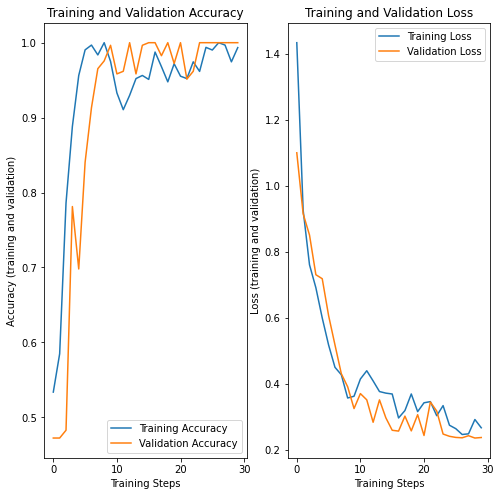

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    # img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    # img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_144412460_BURST001.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


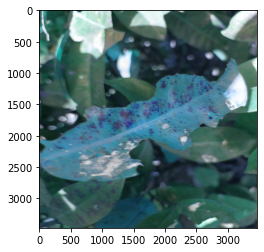

<Figure size 432x288 with 0 Axes>

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_144412460_BURST016.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


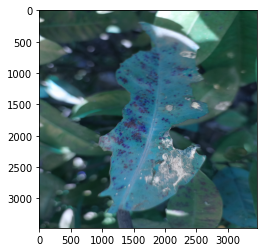

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_143927103_BURST037.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


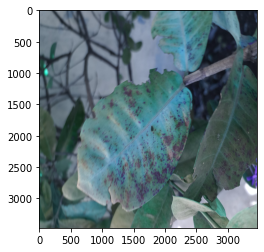

<Figure size 432x288 with 0 Axes>

SOURCE: class: Fresh_Plant, file: Fresh_Plant/IMG20221125142723.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


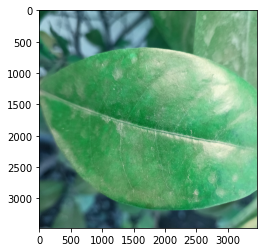

<Figure size 432x288 with 0 Axes>

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_144543057_BURST009.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


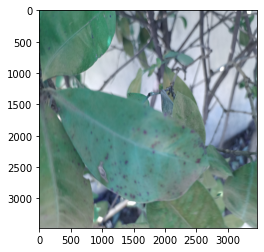

<Figure size 432x288 with 0 Axes>

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_144543057_BURST026.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


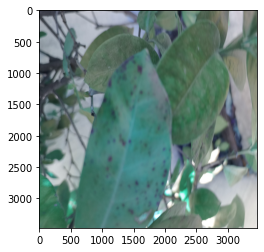

<Figure size 432x288 with 0 Axes>

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_144543057_BURST006.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


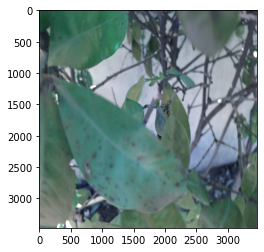

<Figure size 432x288 with 0 Axes>

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_144455726_BURST027.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


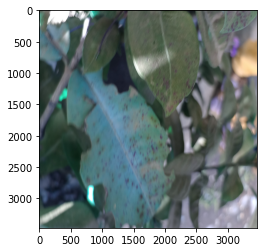

<Figure size 432x288 with 0 Axes>

SOURCE: class: Diseased_Plant, file: Diseased_Plant/IMG_20221125_144455726_BURST034.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


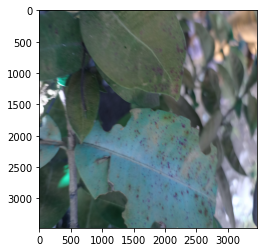

<Figure size 432x288 with 0 Axes>

SOURCE: class: Fresh_Plant, file: Fresh_Plant/IMG20221125142628.jpg
PREDICTED: class: fresh plant, confidence: 1.000000


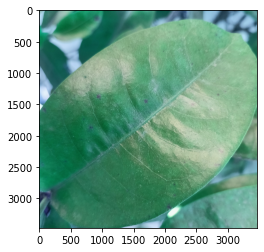

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

Perticular Folder

In [ ]:
import os
import tensorflow as tf

import matplotlib.pylab as plt

    
IMAGE_SIZE = (pixelsx, pixelsy)



def load_image(filename):
    # img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    # img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]), 3 )
    # img = img /255
    img = cv2.imread(filename)
    # img = img / 256
    # img = cv2.resize(img, IMAGE_SIZE)
    # img = cv2.resize(img,(150,150),3)
    
    return img

def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}


sourse = '/content/drive/MyDrive/ESP32cam_images' +'/'

for filename in os.listdir(sourse):
    if filename.endswith(".jpg"): 
        # path = '"' + sourse + filename + '"'
        path =  sourse + filename
        img = load_image(path)
        plt.imshow(img)   
        plt.show()
        print(path)
        # img = np.reshape(img,[224,224,3])
        # prediction = predict(img)
        prediction = predict(img)
        print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
        print("\n")


FileNotFoundError: ignored

Back To Work

In [ ]:
filename = '/content/drive/MyDrive/Project_IP/appleRust.jpg'

print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
 
img = load_image(filename)
prediction = predict(img)
print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
plt.imshow(img)
# plt.figure(idx)    
plt.show()